In [1]:
import torch 
import torch.nn as nn
import lightning as L

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

In [ ]:
class PredictionData(Dataset):
    def __init__(self, input_size, atmosphericData, runoff, atmosStats, runoffStats, transform=None):

        self.input_size = input_size
        runoffData = runoff.transpose("time", "river")
        
        X = ((atmosphericData - atmosStats[0])/atmosStats[1]).compute()
        y = ((runoffData - runoffStats[0])/runoffStats[1]).compute()
        
        xStacked = X.to_array(dim='variable')
        xStacked = xStacked.transpose("time", "variable", "y", "x")

        assert xStacked.data.ndim == 4
        self.x = torch.tensor(xStacked.data, dtype=torch.float32)
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)

In [2]:
datapath="/silor/boergel/paper/runoff_prediction/data"
datapathPP="/silod9/boergel/runoff_prediction_ERA5_downscaled_coupled_model/resampled"

The model was trained for the period 1979 - 2011. All predictions outside of this time period can be viewed as test data.

Runoff data is only available until the end of 2018.

In [3]:
# Set seed for reproducible
L.seed_everything(123)

# Use available tensor cores
torch.set_float32_matmul_precision("medium")

datapath="/silor/boergel/paper/runoff_prediction/data"
datapathPP="/silod9/boergel/runoff_prediction_ERA5_downscaled_coupled_model/resampled"

runoff = xr.open_dataset(f"{datapath}/runoff.nc").load()
runoff = runoff.sel(time=slice("1979", "2011"))
runoff = runoff.roflux

DataRain = xr.open_dataset(f"{datapathPP}/rain.nc")
DataRain = DataRain.sel(time=slice("1979", "2011"))
DataRain = DataRain.rain.squeeze()
DataRain = DataRain.drop(["lon","lat"])
DataRain = DataRain.rename({"rlon":"x","rlat":"y"})

DataShumi = xr.open_dataset(f"{datapathPP}/QV.nc")
DataShumi = DataShumi.sel(time=slice("1979", "2011"))
DataShumi = DataShumi.QV.squeeze()
DataShumi = DataShumi.drop(["lon","lat"])
DataShumi = DataShumi.rename({"rlon":"x","rlat":"y"})

DataWindSpeed = xr.open_dataset(f"{datapathPP}/speed.nc")
DataWindSpeed = DataWindSpeed.sel(time=slice("1979", "2011"))
DataWindSpeed = DataWindSpeed.speed.squeeze()
DataWindSpeed = DataWindSpeed.drop(["lon","lat"])
DataWindSpeed = DataWindSpeed.rename({"rlon":"x","rlat":"y"})

DataTemp = xr.open_dataset(f"{datapathPP}/T.nc")
DataTemp = DataTemp.sel(time=slice("1979", "2011"))
DataTemp = DataTemp.T.squeeze()
DataTemp = DataTemp.drop(["lon","lat"])
DataTemp = DataTemp.rename({"rlon":"x","rlat":"y"})

assert DataShumi.time[0] == DataRain.time[0] == DataWindSpeed.time[0]
assert len(DataShumi.time) == len(DataRain.time) == len(DataWindSpeed.time)

data = xr.merge([DataRain, DataShumi, DataWindSpeed, DataTemp])
assert len(runoff.time) == len(data.time)

Global seed set to 123


In [4]:
nan_check_rain = data['rain'].isnull().any(dim=["x", "y"])
nan_check_shumi = data['QV'].isnull().any(dim=["x", "y"])
nan_check_speed = data['speed'].isnull().any(dim=["x", "y"])

combined_nan_check = nan_check_rain | nan_check_shumi | nan_check_speed

nan_timesteps_indices = np.where(combined_nan_check)[0]

print("Indices of timesteps with NaNs:", data.isel(time=nan_timesteps_indices).time)

Indices of timesteps with NaNs: <xarray.DataArray 'time' (time: 0)>
array([], dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 
    height_10m  float32 ...
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


In [5]:
modelParameters = {
    "input_dim": 4,
    "hidden_dim": 9,
    "kernel_size": (7,7),
    "num_layers": 1,
    "batch_first": True,
    "bias": True,
    "return_all_layers": False,
    "dimensions": (222,244),
    "input_size": 30
}

In [6]:
pyTorchBaltNet = BaltNet(modelPar=modelParameters)

In [7]:
LightningBaltNet = LightningModel.load_from_checkpoint(
    checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive2TopOne-v2.ckpt",
    learning_rate=1e-3,
    map_location="cpu",
    model=pyTorchBaltNet,
    cosine_t_max=100
)

In [8]:
dataLoader = AtmosphereDataModule(
    atmosphericData=data,
    runoff=runoff,
    batch_size=50,
    input_size=modelParameters["input_size"],
    num_workers=16
)

dataLoader.setup()

In [9]:
# dataDataset = AtmosphericDataset(
#     atmosphericData=data.sel(time=slice("1979", "2005")),
#     runoff=runoff.sel(time=slice("1979", "2005")),
#     input_size=modelParameters["input_size"],
# )

In [10]:
# class PredictionData(Dataset):
#     def __init__(self, input_size, atmosphericData, runoff, atmosStats, runoffStats, transform=None):

#         # Length of the sequence
#         self.input_size = input_size

#         # output data - label (y)
#         runoffData = runoff.transpose("time", "river")

        
#         # normalize data
#         X = ((atmosphericData - atmosStats[0])/atmosStats[1]).compute()
#         y = ((runoffData - runoffStats[0])/runoffStats[1]).compute()
        
#         # an additional dimension for the channel is added
#         # to end up with (time, channel, lat, lon)
#         xStacked = X.to_array(dim='variable')
#         xStacked = xStacked.transpose("time", "variable", "y", "x")

#         assert xStacked.data.ndim == 4
#         self.x = torch.tensor(xStacked.data, dtype=torch.float32)
#         self.y = torch.tensor(y.data, dtype=torch.float32)

#     def __getitem__(self, index):
#         return self.x[index:index+(self.input_size)], self.y[index+int(self.input_size)]

#     def __len__(self):
#         return self.y.shape[0]-(self.input_size)

In [11]:
# PredictionDataset = PredictionData(
#     atmosphericData=data.sel(time=slice("2005", "2011")),
#     runoff=runoff.sel(time=slice("2005", "2011")),
#     input_size=modelParameters["input_size"],
#     atmosStats=dataDataset.atmosphericStats,
#     runoffStats=dataDataset.runoffDataStats,
# )

In [12]:
# predict_dataloader = DataLoader(
#     PredictionDataset,
#     batch_size=64,
#     shuffle=False,
#     drop_last=True
#     )

In [13]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [25]:
dataLoader.setup(stage="")

In [26]:
concatenated_predictions = torch.cat(predictions, dim=0)
rescaledRunoffData = concatenated_predictions*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data

In [24]:
origianlRunoffData = runoff.transpose("time", "river")
origianlRunoffData = origianlRunoffData.resample(time="1D").mean()

In [ ]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffData.data,
    coords={
        "time": origianlRunoffData.sel(time=slice("2005", "2011")).time[modelParameters["input_size"]:],
        "river": origianlRunoffData.river
    }
)


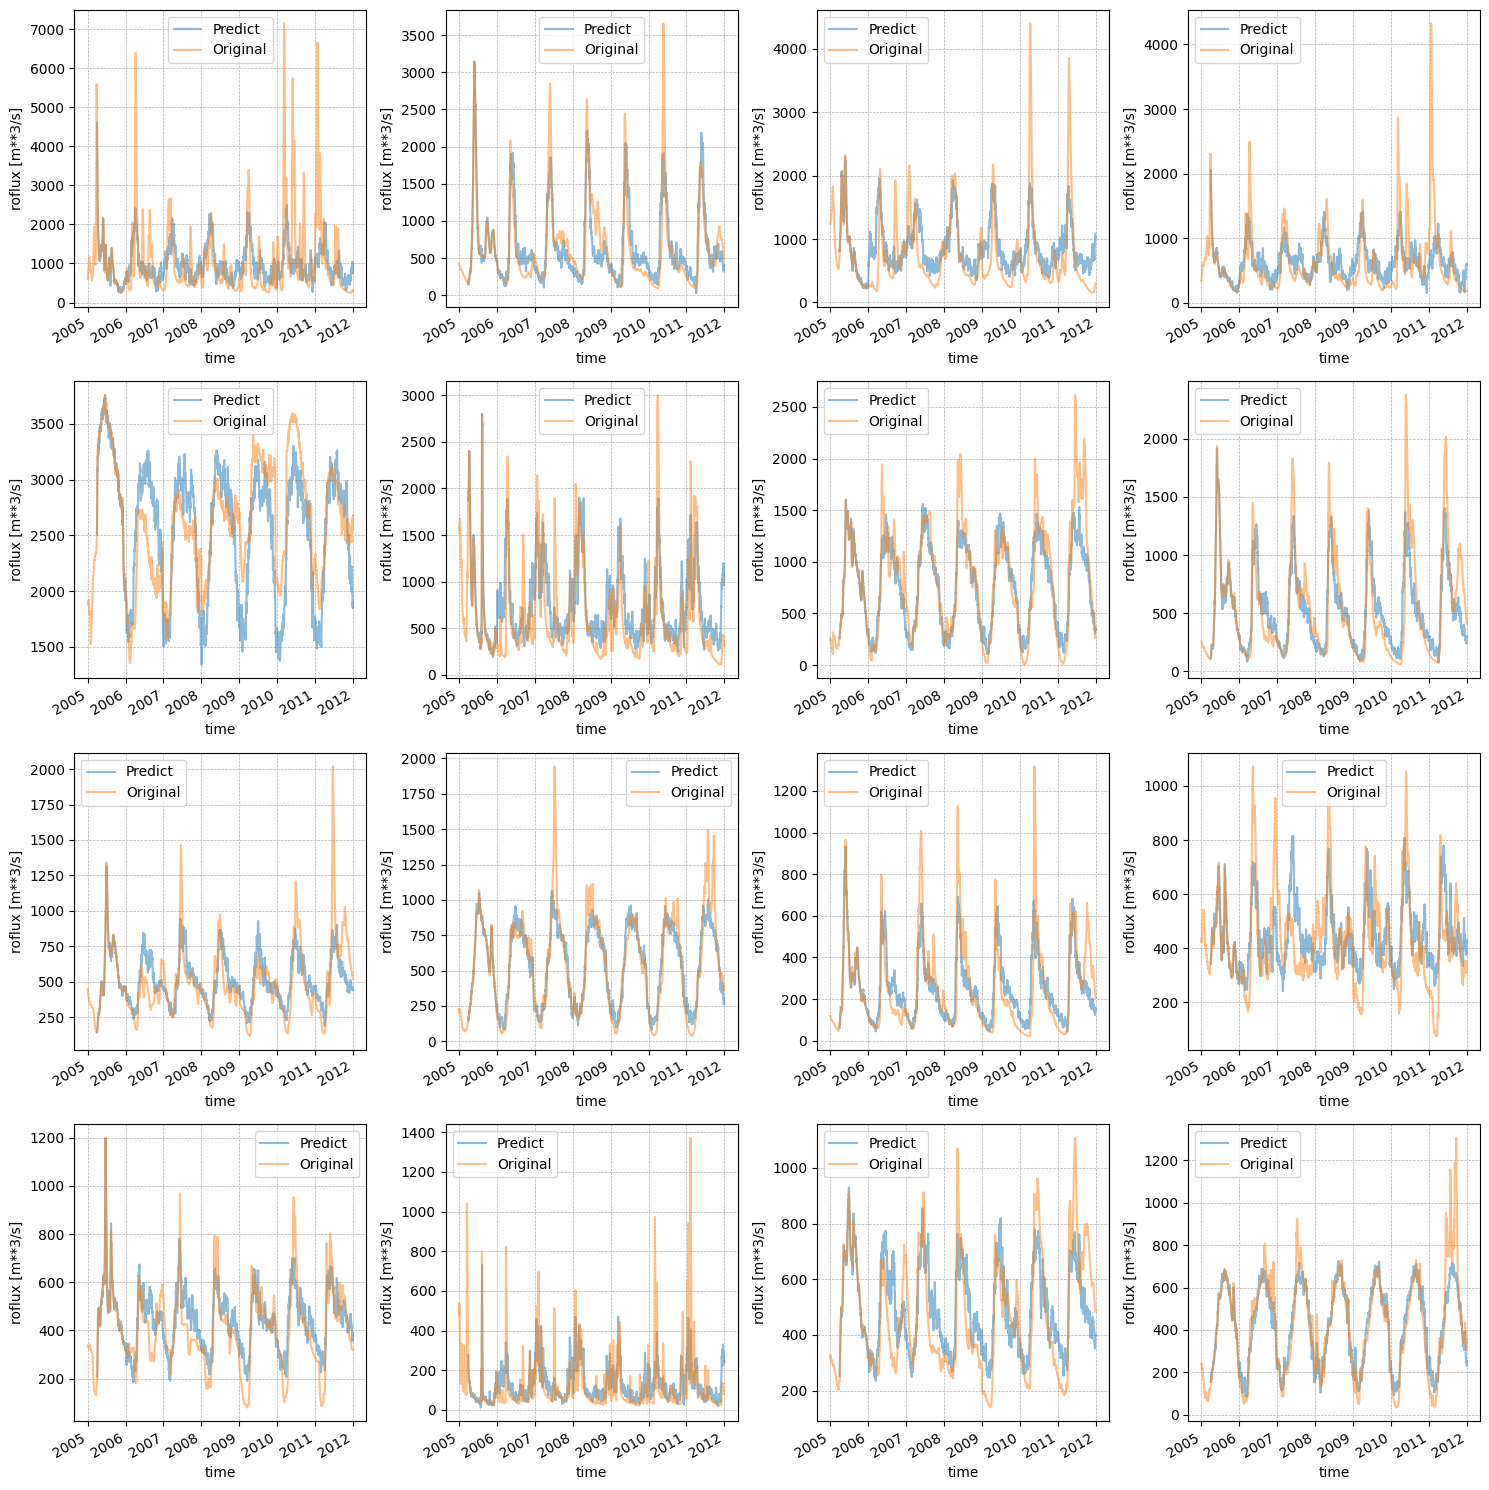

In [ ]:
total_runoff_per_river = origianlRunoffData.max(dim="time")
largest_rivers_indices = np.argsort(-total_runoff_per_river.data)[:16]

f, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    river_index = largest_rivers_indices[i]
    ax.set_title(f"River {river_index + 1}")

    # Plotting data for the specific river index
    rescaledRunoffDataDataset.isel(river=river_index).plot(ax=ax, label="Predict", alpha=.5)
    origianlRunoffData.sel(time=slice("2005", "2011")).isel(river=river_index).plot(ax=ax, label="Original", alpha=0.5)

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()


In [ ]:
# Calculate the total runoff for each river
total_runoff_per_river = origianlRunoffData.isel(time=slice(None, -150)).max(dim="time")

# Get the indices of the 16 largest rivers
largest_rivers_indices = np.argsort(-total_runoff_per_river)[:25]

# Calculate the total runoff of the 16 largest rivers
total_runoff_largest_rivers = total_runoff_per_river.isel(river=largest_rivers_indices).sum()

# Calculate the total runoff of all rivers
total_runoff_all_rivers = total_runoff_per_river.sum()

# Calculate the percentage contribution of the 16 largest rivers
percentage_contribution = (total_runoff_largest_rivers / total_runoff_all_rivers) * 100

print(f"Contribution of the 25 largest rivers to total runoff: {percentage_contribution:.2f}%")


Contribution of the 25 largest rivers to total runoff: 70.75%


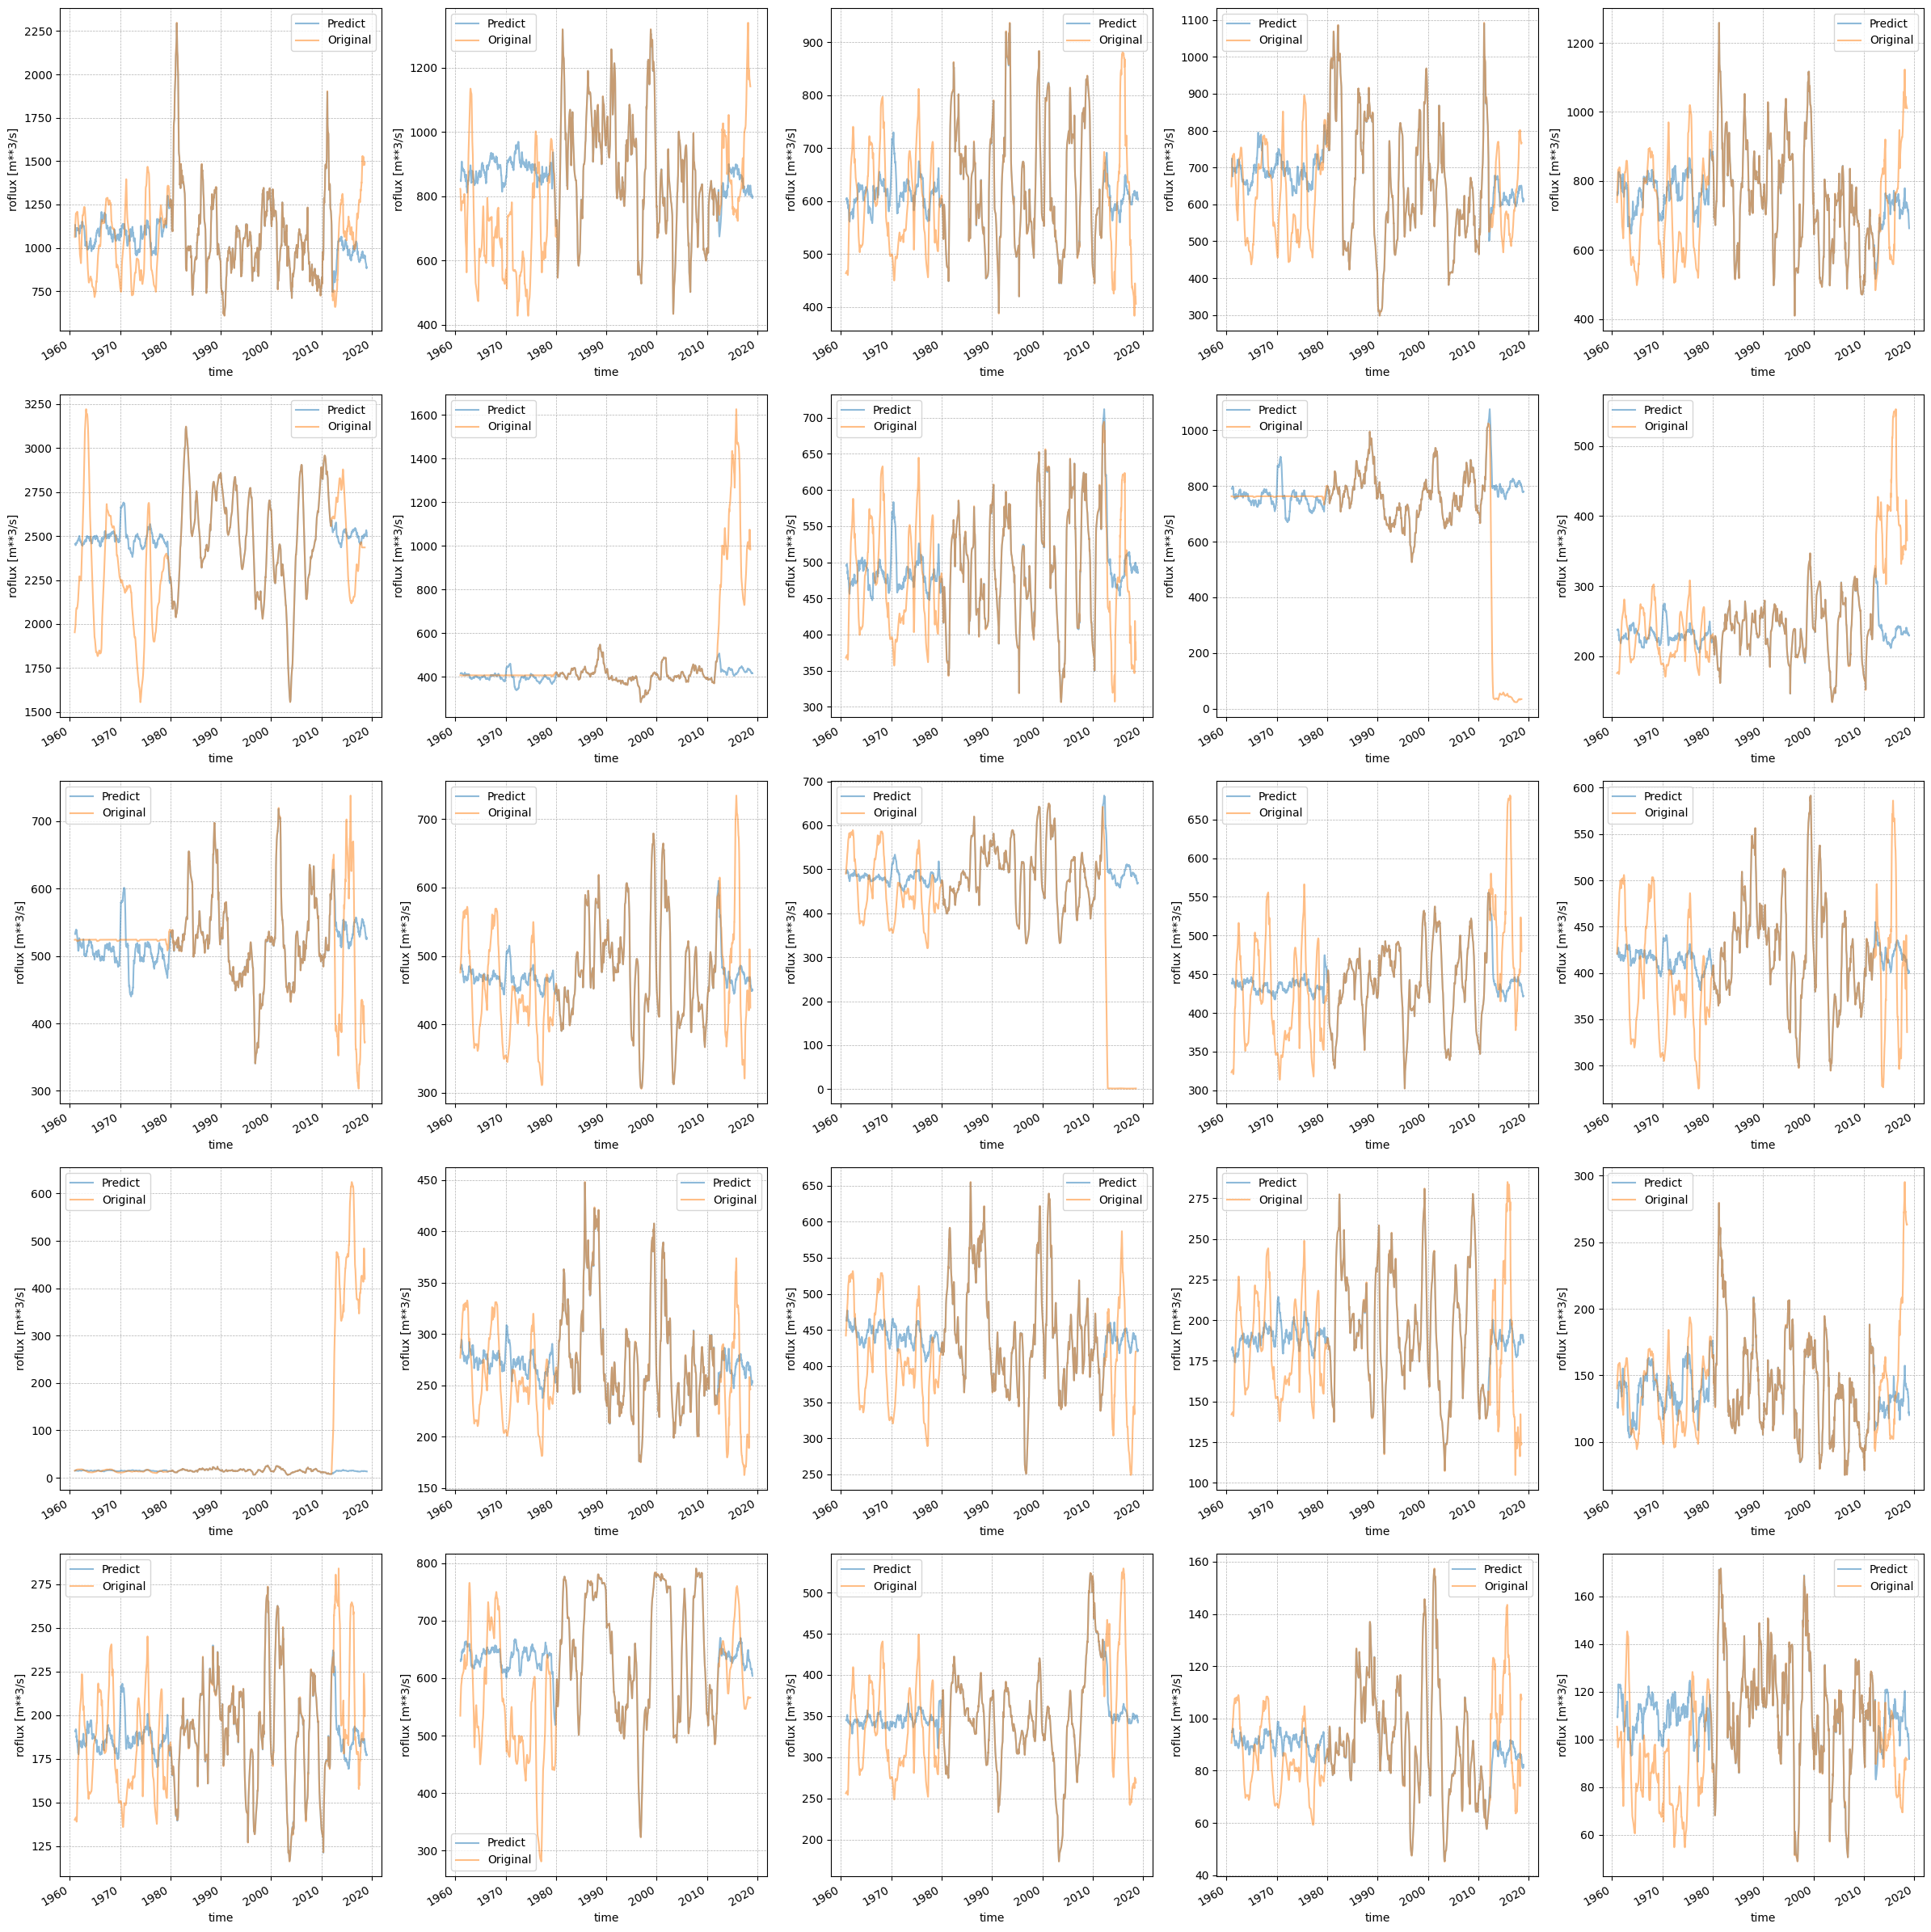

In [ ]:
total_runoff_per_river = origianlRunoffData.isel(time=slice(None, -150)).max(dim="time")
largest_rivers_indices = np.argsort(-total_runoff_per_river.data)[:25]

f, axs = plt.subplots(5, 5, figsize=(24, 24))

for i, ax in enumerate(axs.ravel()):
    river_index = largest_rivers_indices[i]
    ax.set_title(f"River {river_index + 1}")

    # Plotting data for the specific river index
    rescaledRunoffDataDataset.isel(river=river_index).fillna(rescaledRunoffDataDataset.isel(river=river_index).mean()).rolling(time=365).mean().plot(ax=ax, label="Predict", alpha=.5)
    origianlRunoffData.isel(river=river_index).isel(time=slice(None, -150)).rolling(time=365).mean().plot(ax=ax, label="Original", alpha=0.5)

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()


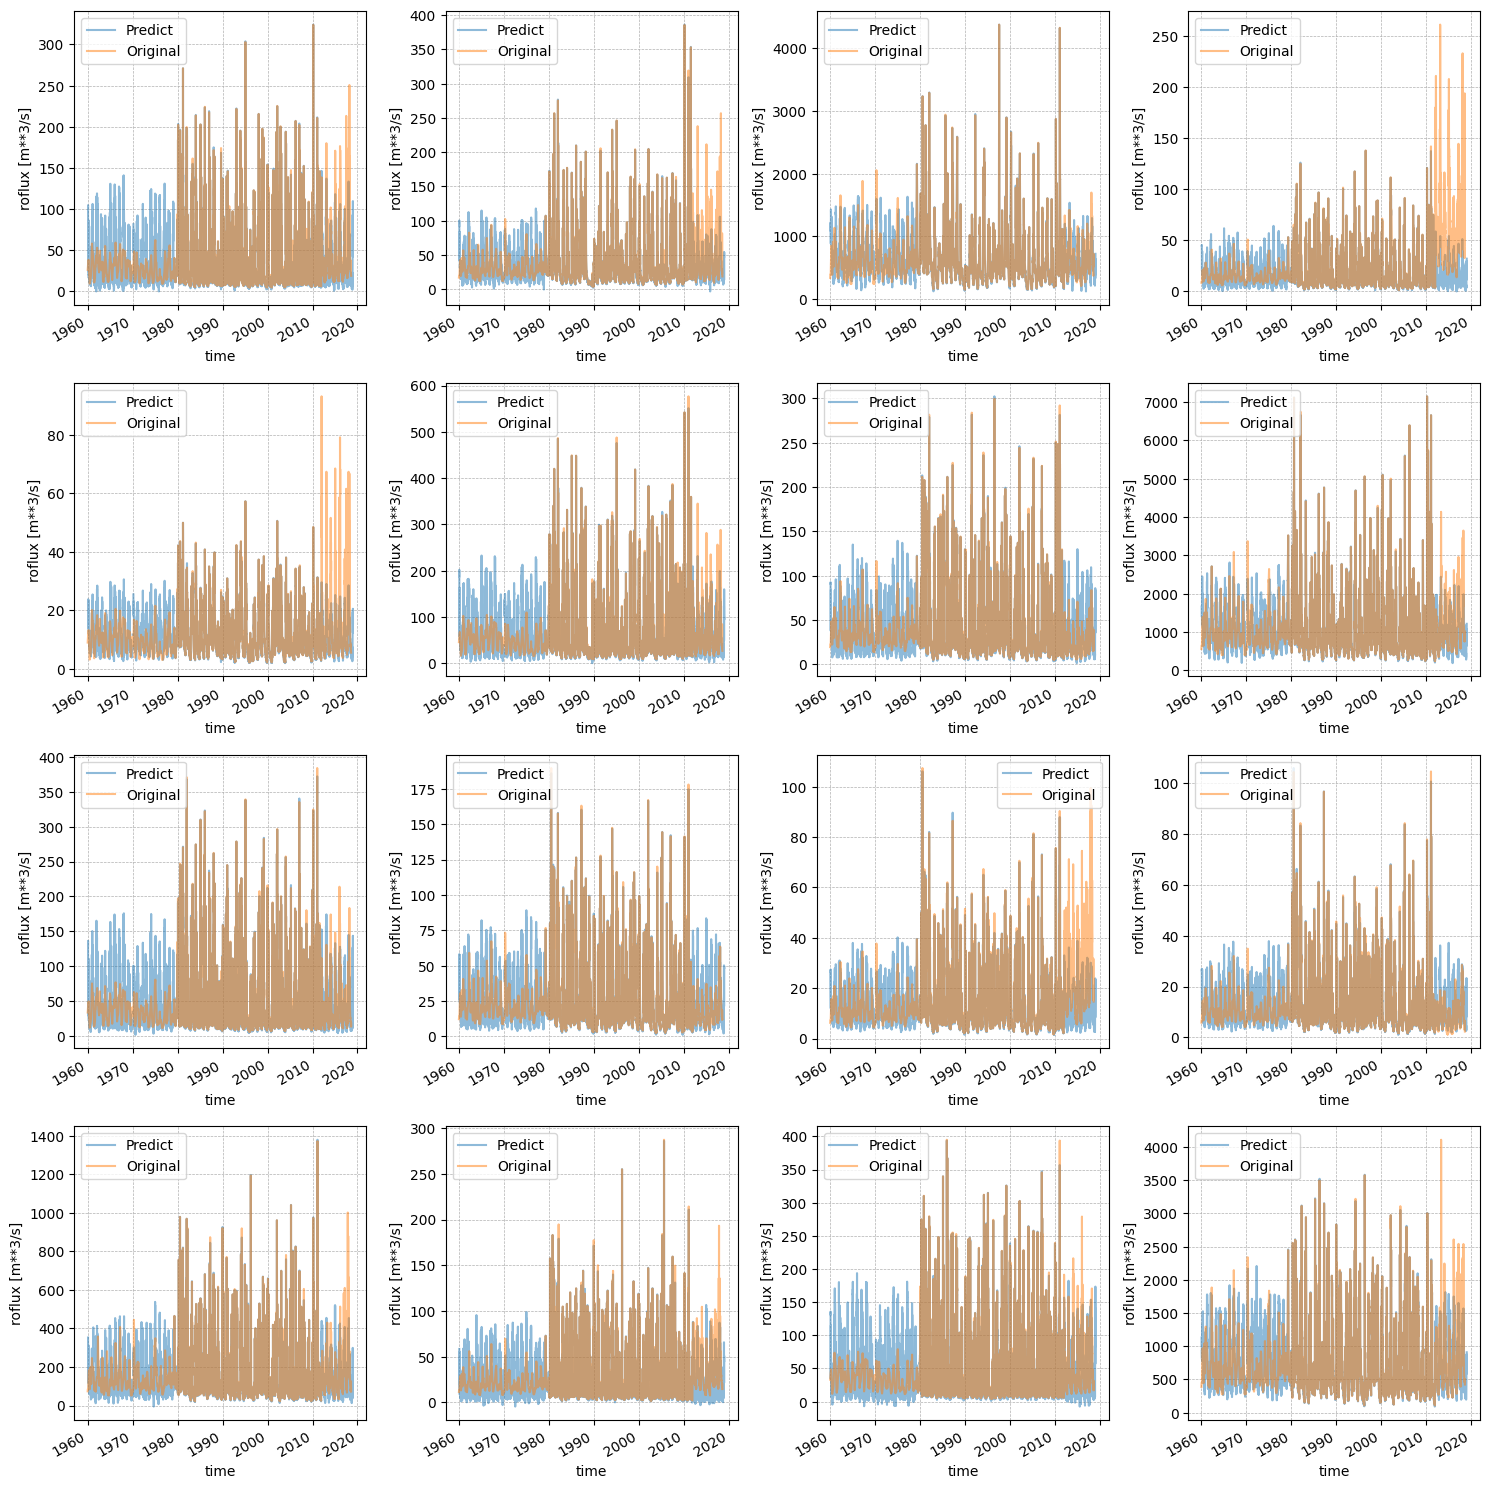

In [ ]:
f, axs = plt.subplots(4,4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    ax.set_title(f"River {i+1}")
    rescaledRunoffDataDataset.isel(river=i).plot(ax=ax, label = "Predict", alpha=.5)
    origianlRunoffData.isel(river=i).isel(time=slice(None, -150)).plot(ax=ax, label="Original", alpha=0.5)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
plt.tight_layout()

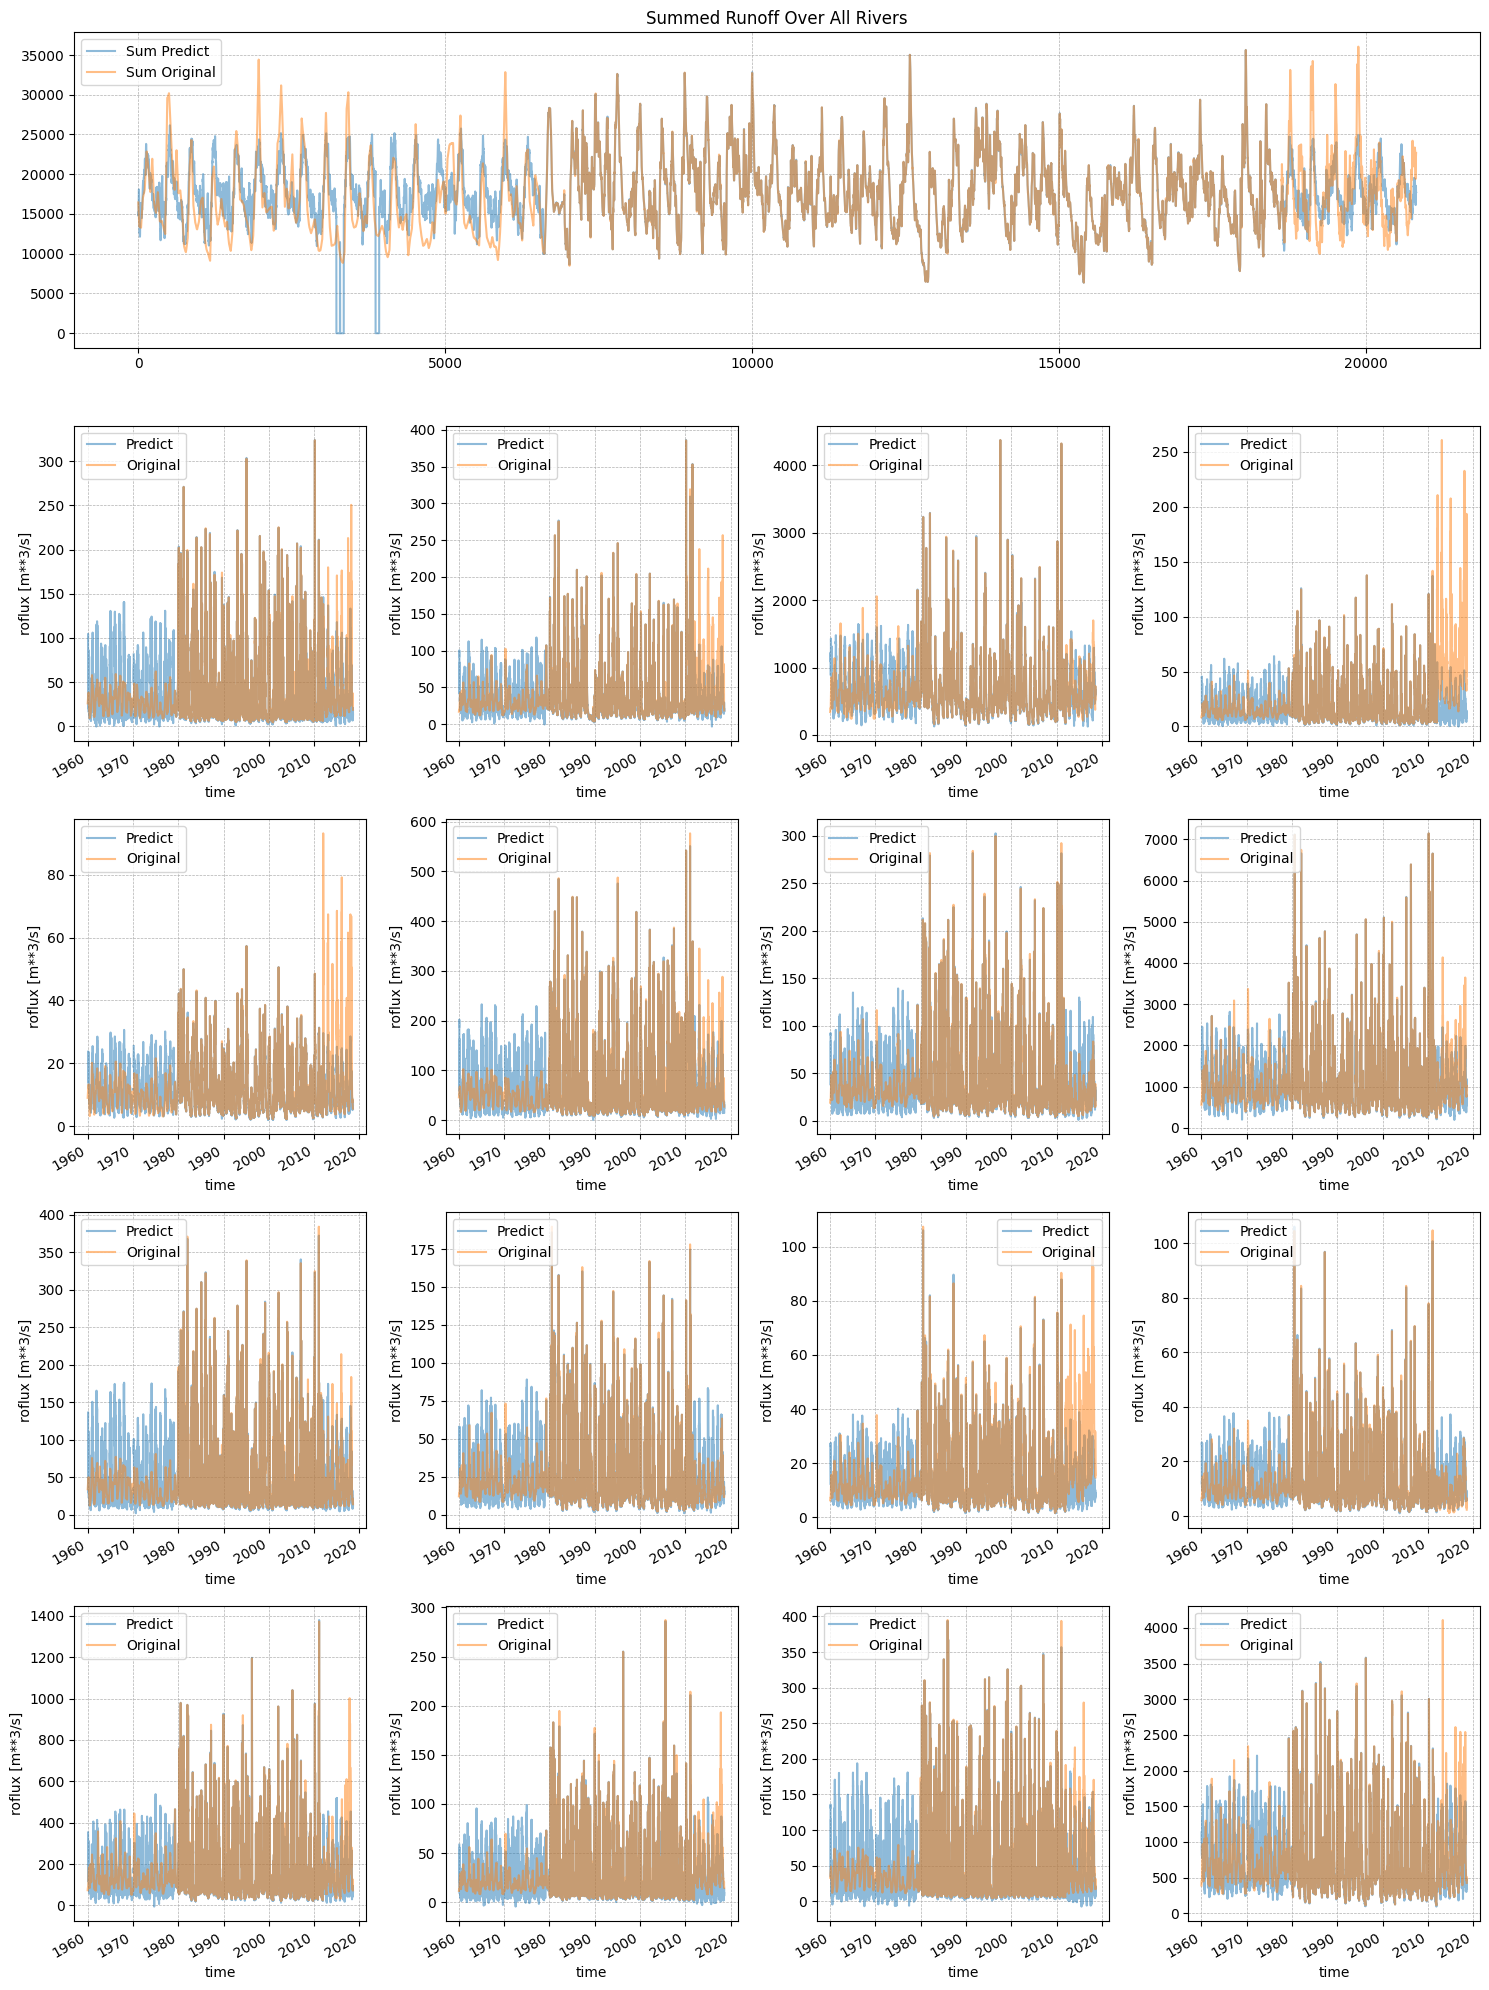

In [ ]:
# Sum the runoff data over all rivers
sum_rescaled_runoff = rescaledRunoffDataDataset.sel(time=slice("1961", "2017")).sum(dim='river')
sum_original_runoff = origianlRunoffData.sel(time=slice("1961", "2017")).sum(dim='river')

f = plt.figure(figsize=(15, 20))

# Plot the summed data in the first row
ax_summed = plt.subplot2grid((5, 4), (0, 0), colspan=4, fig=f)
ax_summed.plot(sum_rescaled_runoff, label="Sum Predict", alpha=0.5)
ax_summed.plot(sum_original_runoff, label="Sum Original", alpha=0.5)
ax_summed.set_title("Summed Runoff Over All Rivers")
ax_summed.legend()
ax_summed.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot individual rivers in the remaining subplots
for i in range(16):  # Adjust this range based on the number of rivers
    row, col = divmod(i, 4)  # Calculate the correct row and column
    ax = plt.subplot2grid((5, 4), (row + 1, col), fig=f)  # Notice the row + 1
    ax.set_title(f"River {i + 1}")
    rescaledRunoffDataDataset.isel(river=i).isel(time=slice(None, -150)).plot(ax=ax, label="Predict", alpha=0.5)
    origianlRunoffData.isel(river=i).isel(time=slice(None, -150)).plot(ax=ax, label="Original", alpha=0.5)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()



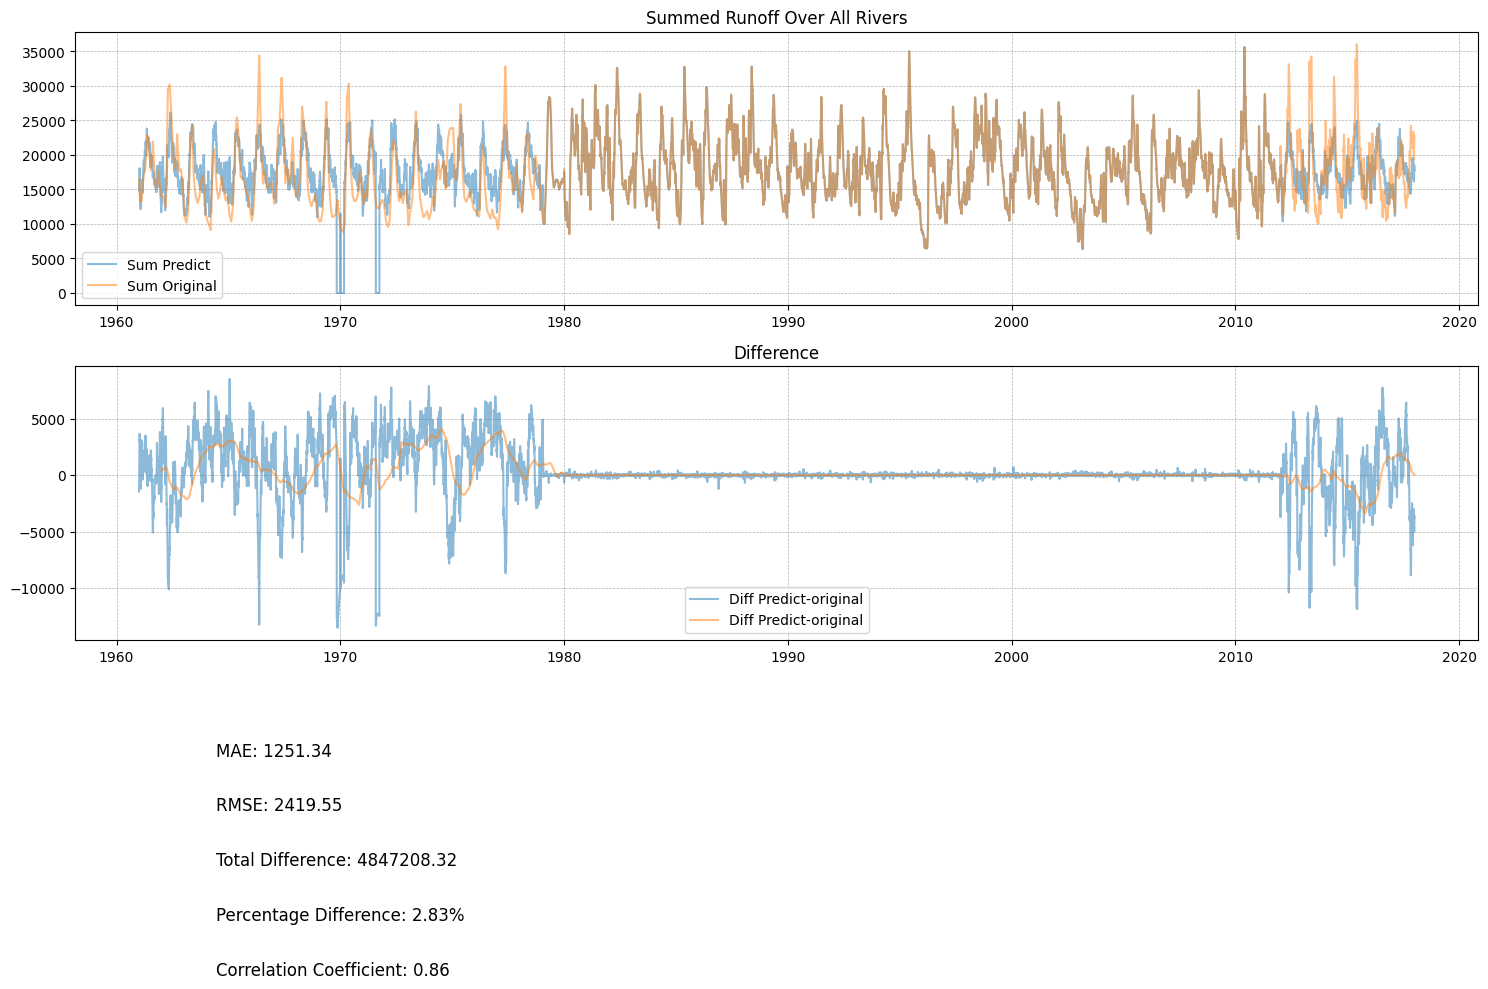

In [ ]:
f = plt.figure(figsize=(15, 20))

# Summed data plot
ax_summed = plt.subplot2grid((6, 4), (0, 0), colspan=4, fig=f)
ax_summed.plot(sum_rescaled_runoff.time, sum_rescaled_runoff, label="Sum Predict", alpha=0.5)
ax_summed.plot(sum_rescaled_runoff.time, sum_original_runoff, label="Sum Original", alpha=0.5)
ax_summed.set_title("Summed Runoff Over All Rivers")
ax_summed.legend()
ax_summed.grid(True, which='both', linestyle='--', linewidth=0.5)

# Summed data plot
ax_summed = plt.subplot2grid((6, 4), (1, 0), colspan=4, fig=f)
ax_summed.plot(sum_rescaled_runoff.time, sum_rescaled_runoff-sum_original_runoff, label="Diff Predict-original", alpha=0.5)
ax_summed.plot(sum_rescaled_runoff.time, (sum_rescaled_runoff-sum_original_runoff).rolling(time=365).mean(), label="Diff Predict-original", alpha=0.5)
ax_summed.set_title("Difference")
ax_summed.legend()
ax_summed.grid(True, which='both', linestyle='--', linewidth=0.5)

# Statistics
mae = np.mean(np.abs(sum_rescaled_runoff - sum_original_runoff))
rmse = np.sqrt(np.mean((sum_rescaled_runoff - sum_original_runoff)**2))
total_diff = np.sum(sum_rescaled_runoff - sum_original_runoff)
percent_diff = np.mean((sum_rescaled_runoff - sum_original_runoff) / sum_original_runoff) * 100
correlation = np.corrcoef(sum_rescaled_runoff, sum_original_runoff)[0, 1]

# Display statistics
ax_stats = plt.subplot2grid((6, 4), (2, 0), colspan=4, fig=f)
ax_stats.text(0.1, 0.8, f"MAE: {mae:.2f}", fontsize=12)
ax_stats.text(0.1, 0.6, f"RMSE: {rmse:.2f}", fontsize=12)
ax_stats.text(0.1, 0.4, f"Total Difference: {total_diff:.2f}", fontsize=12)
ax_stats.text(0.1, 0.2, f"Percentage Difference: {percent_diff:.2f}%", fontsize=12)
ax_stats.text(0.1, 0, f"Correlation Coefficient: {correlation:.2f}", fontsize=12)
ax_stats.axis('off')

plt.tight_layout()
plt.show()

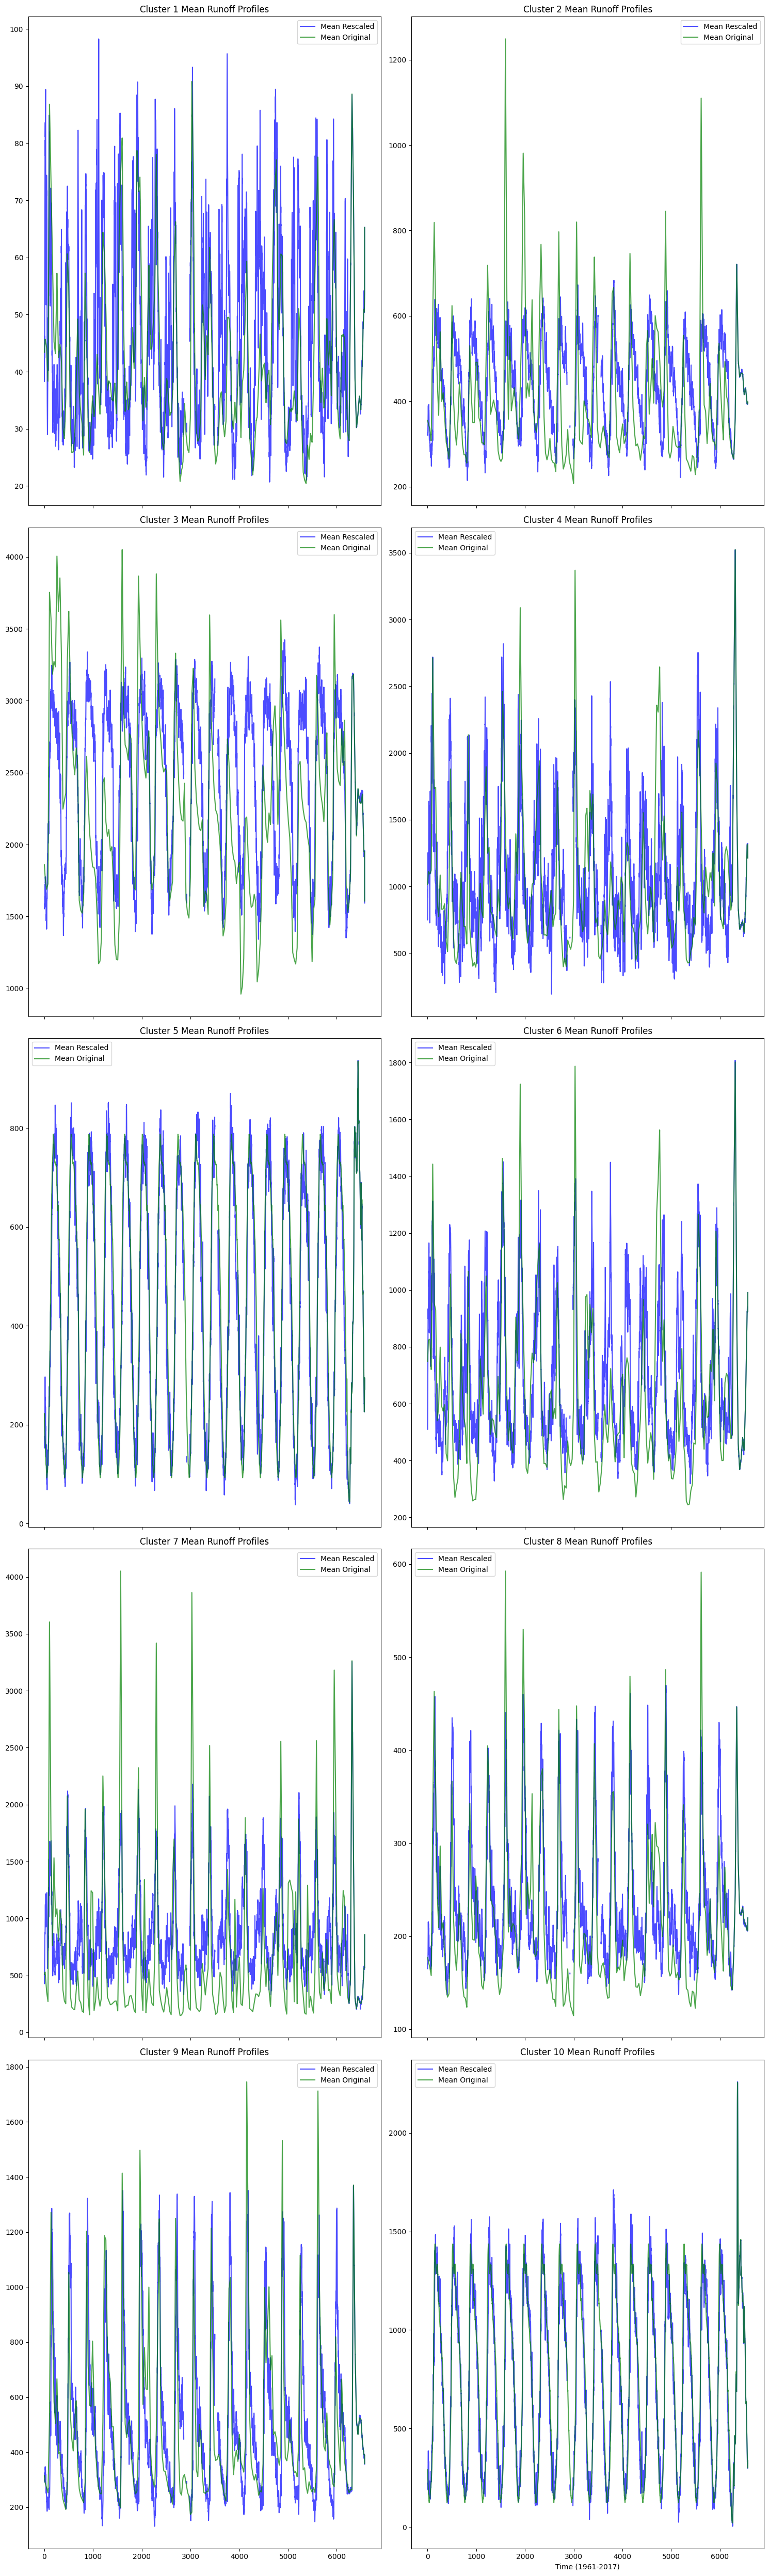

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

rescaled_data = rescaledRunoffDataDataset.sel(time=slice("1962", "1979")).to_numpy()
original_data = origianlRunoffData.sel(time=slice("1962", "1979")).to_numpy()

# # Impute NaN values for both datasets
# imputer = SimpleImputer(strategy='mean')
# imputed_rescaled_data = imputer.fit_transform(rescaled_data.T)  # Shape: (rivers, time_points)
# imputed_original_data = imputer.fit_transform(original_data.T)  # Shape: (rivers, time_points)

# Perform k-means clustering on one dataset, here using rescaled data
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100).fit(original_data.T)

# Get cluster labels
labels = kmeans.labels_
# Plotting
f, axs = plt.subplots(int(n_clusters/2), 2, figsize=(15, 5 * n_clusters), sharex=True)

# Create a color map for the clusters
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    ax = axs.ravel()[i]
    
    # Select rivers belonging to the current cluster for both datasets
    cluster_indices = np.where(labels == i)[0]
    cluster_rescaled = rescaled_data.T[cluster_indices]
    cluster_original = original_data.T[cluster_indices]

    # Calculate the mean profile for each dataset in the cluster
    mean_rescaled = cluster_rescaled.mean(axis=0)
    mean_original = cluster_original.mean(axis=0)

    # Plot each dataset's mean profile for the cluster
    ax.plot(mean_rescaled, label='Mean Rescaled', color='blue', alpha=0.7)
    ax.plot(mean_original, label='Mean Original', color='green', alpha=0.7)
    ax.set_title(f'Cluster {i+1} Mean Runoff Profiles')
    ax.legend()

plt.xlabel('Time (1961-2017)')
plt.tight_layout()
plt.show()
